# **Predictors of mental health illness** <br>

### **Question:**
**Can you predict whether a patient should be treated of his/her mental illness or not according to the values obtained in the dataset?**

The proccess is the following:
1. [Library and data loading](#Library_and_data_loading)
2. [Data cleaning](#Data_cleaning)
3. [Encoding data](#Encoding_data)
4. [Covariance Matrix. Variability comparison between categories of variables](#Covariance_Matrix)
5. [Some charts to see data relationship](#Some_charts_to_see_data_relationship)
6. [Scaling and fitting](#Scaling_and_fitting)
7. [Tuning](#Tuning)
8. [Evaluating models](#Evaluating_models)    
    1. [Logistic Eegression](#Logistic_regressio)
    2. [KNeighbors Classifier](#KNeighborsClassifier)
    3. [Decision Tree Classifier](#Decision_Tree_classifier)
    4. [Random Forests](#Random_Forests)
    5. [Bagging](#Bagging)
    6. [Boosting](#Boosting)
    7. [Stacking](#Stacking)
9. [Predicting with Neural Network](#Predicting_with_Neural_Network)
10. [Success method plot](#Success_method_plot)
11. [Creating predictions on test set](#Creating_predictions_on_test_set)
12. [Submission](#Submission)
13. [Conclusions](#Conclusions)


<a id='Library_and_data_loading'></a>
## **1. Library and data loading** ##

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#libraries for the plots
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp
from math import sqrt
from scipy import stats
from scipy.stats import randint

# prepocessing data
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Neural Network
from sklearn.neural_network import MLPClassifier
#the version from sklearn.grid_search import RandomizedSearchCV is deprecated. We sustitute it with:
from sklearn.model_selection import RandomizedSearchCV

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Stacking
from mlxtend.classifier import StackingClassifier

### Import the dataset
Input data files are available in the local directory, any results we write to the current directory are saved as output.

In [2]:
#reading in CSV's from a file path
train_df = pd.read_csv('survey.csv')

#whats the data row count?
print(train_df.shape)
    
#whats the distribution of the data?
print(train_df.describe())
    
#What types of data do i have?
print(train_df.info())


(1259, 27)
                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-n

<a id='Data_cleaning'></a>
## **2. Data cleaning** ##
During this phase we generate a new dataframe containing the number of missing values and their proportion in each category.

In [3]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
comments,1095,0.869738
state,515,0.409055
work_interfere,264,0.209690
self_employed,18,0.014297
benefits,0,0.000000


#### Dealing with missing data 
Here we delete from the dataset tree (change in two) columns from which the information aren't econdable.

In [4]:
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)

In [5]:
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


**Cleaning NaN**

In [6]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)   

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [7]:
#clean 'Gender'
#Slower case all columm's elements
gender = train_df['Gender'].str.lower()

#Select unique elements
gender = train_df['Gender'].unique()

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():
    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Unidentifable categorical data of gender
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]
#Checking that there are only this 3 geneders in the dataset
print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [8]:
#complete missing age with mean
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

# Fill with median() values < 18 and > 120
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

# TO EVALUATE IF CHANGE A LITTLE BIT THE RANGE OF AGE.
#Ranges of Age
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)
#with the pandas.cut() we create the bin values into discrete intervals.


In [9]:
#There are only 0.014% of self employed so let's change NaN to NOT self_employed
#Replace "NaN" string from defaultString
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [10]:
#There are only 0.20% of self work_interfere so let's change NaN to "Don't know"
#Replace "NaN" string from defaultString

train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


<a id='Encoding_data'></a>
## **3. Encoding data**

We want to include the information about the Country in our data encodig. For this purpose we thought that a significant parameter could been the happyness level associated to each country according to the [Survey 2016](https://meet.google.com/linkredirect?authuser=0&dest=https%3A%2F%2Fwww.kaggle.com%2Funsdsn%2Fworld-happiness). \
Therefore we substitute the name of the Country with the normalized score.

In [11]:
train_df

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,37,female,United States,No,No,Yes,Often,6-25,No,Yes,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,31-65
1,44,male,United States,No,No,No,Rarely,More than 1000,No,No,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,31-65
2,32,male,Canada,No,No,No,Rarely,6-25,No,Yes,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,31-65
3,31,male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,31-65
4,31,male,United States,No,No,No,Never,100-500,Yes,Yes,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,31-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26,male,United Kingdom,No,No,Yes,Don't know,26-100,No,Yes,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,21-30
1255,32,male,United States,No,Yes,Yes,Often,26-100,Yes,Yes,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,31-65
1256,34,male,United States,No,Yes,Yes,Sometimes,More than 1000,No,Yes,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,31-65
1257,46,female,United States,No,No,No,Don't know,100-500,Yes,Yes,...,Don't know,Yes,No,No,No,No,No,No,No,31-65


In [12]:
#Encoding data
country=train_df.Country
happyness_df = pd.read_csv('2016.csv')
scaler = MinMaxScaler() #normalize the values
happyness_df['Happiness Score'] = scaler.fit_transform(happyness_df[['Happiness Score']])
values = happyness_df['Happiness Score']
keys = happyness_df['Country']
dictionary = dict(zip(keys,values))
train_df=train_df.drop(['Country'],axis=1)

labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    #LabelEncoder() is used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.
    le.fit(train_df[feature])
    
    #we create a dictionary to associate each category to each encoding number
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_))) 
    #transform () fits label encoder and return encoded labels
    train_df[feature] = le.transform(train_df[feature])
    
    # Get labels
    labelKey = 'label_' + feature #name
    labelValue = [*le_name_mapping] #value
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

train_df['Country'] = country.map(dictionary)
train_df.head()

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_employees ['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000']
label_remote_work ['No', 'Yes']
label_tech_company ['No', 'Yes']
label_benefits ["Don't know", 'No', 'Yes']
label_care_options ['No', 'Not sure', 'Yes']
label_wellness_program ["Don't know", 'No', 'Yes']
label_seek_help ["Don't know", 'No', 'Yes']
label_anonymity ["Don't know", 'No', 'Yes']
label_leave ["Don't know", 'Somewhat difficult', 'Somewhat easy', 'Very difficult', 'Very easy']
label_mental_health_consequence ['Maybe', 'No', 'Yes']
label_phys_health_consequence ['Maybe', 'No', 'Yes']
label_cow

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range,Country
0,19,0,0,0,1,2,4,0,1,2,...,1,1,1,2,1,0,2,0,2,0.908678
1,26,1,0,0,0,3,5,0,0,0,...,0,1,0,0,1,1,0,0,2,0.908678
2,14,1,0,0,0,3,4,0,1,1,...,1,1,2,2,2,2,1,0,2,0.973599
3,13,1,0,1,1,2,2,0,1,1,...,2,2,1,0,0,0,1,1,2,0.826661
4,13,1,0,0,0,1,1,1,1,2,...,1,1,1,2,2,2,0,0,2,0.908678


<a id='Covariance_Matrix'></a>
## **4. Covariance Matrix. Variability comparison between categories of variables** 

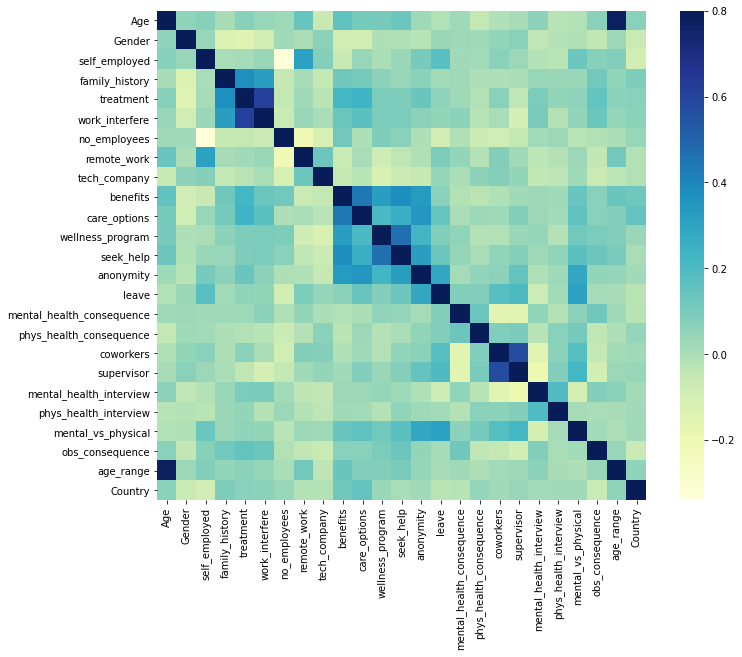

In [13]:
#correlation matrix
corrmat = train_df.corr() #Compute pairwise correlation of columns
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu");
plt.show()

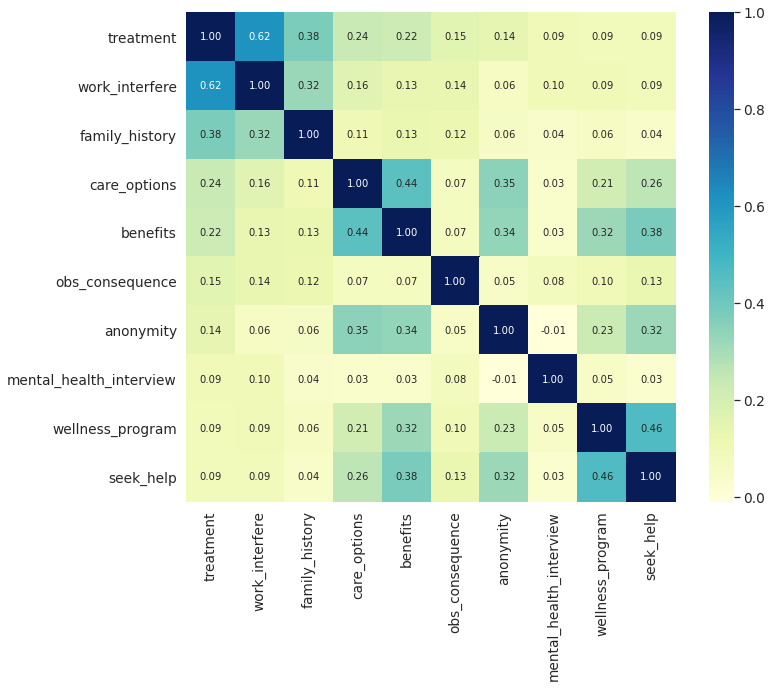

In [14]:
#treatment correlation matrix
k = 10 #number of variables for heatmap
#appling a sort of filter on the categories, taking only the ones that are more correlated with the column 'treatment'
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T) #Return Pearson product-moment correlation coefficients (numeric version of the heatmap)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm,  cmap="YlGnBu",cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<a id='Some_charts_to_see_data_relationship'></a>
## **5. Some charts to see data relationship** 

Distribiution and density by Age separate by treatment.

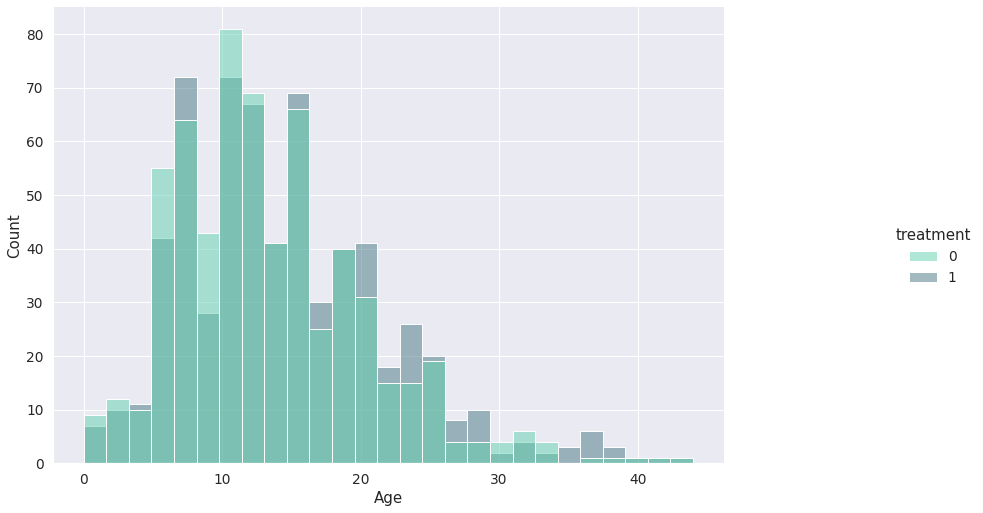

In [15]:
g=sns.displot(train_df, x="Age", hue="treatment",palette=['#61D1B1','#477781']);
g.fig.set_size_inches(15,8)

How many people has been treated?

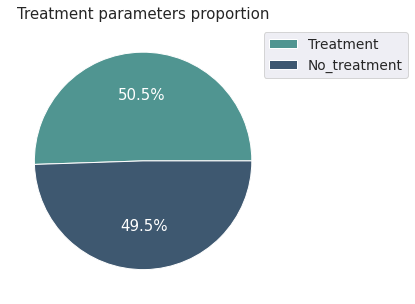

In [16]:
n_ones = train_df["treatment"].sum()
n_zeroes = len(train_df) - n_ones
plt.figure(figsize = (5,5));
plt.pie([n_ones,n_zeroes],colors=['#509591', '#3E5870'], autopct='%1.1f%%',textprops={'color':"w"});
plt.title('Treatment parameters proportion');
plt.legend(labels = ["Treatment" , "No_treatment"],loc='best',bbox_to_anchor=(1,0.5, 0.5, 0.5));

Draw a nested barplot to show probabilities for class and sex

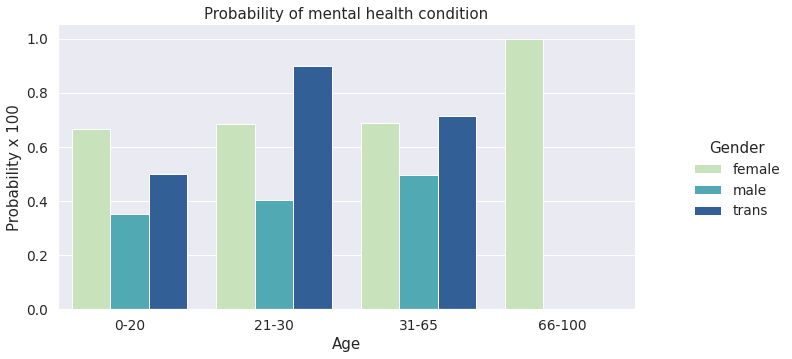

In [17]:
o = labelDict['label_age_range']
colors = 'YlGnBu'
#we have changed the factorplot into the catplot since the first one is deprecated
g = sns.catplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar", palette= colors , ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
# replace legend labels

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for family history

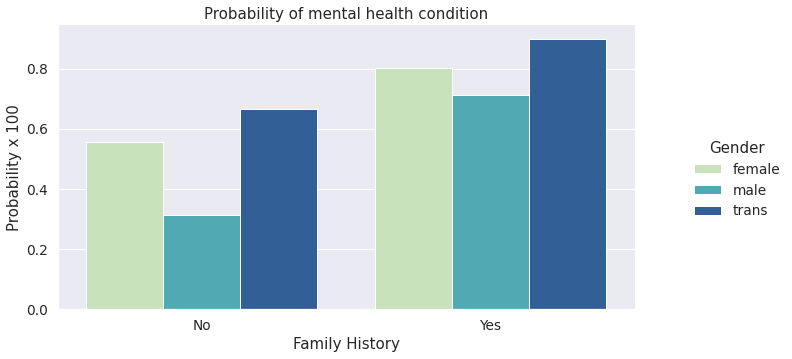

In [18]:
o = labelDict['label_family_history']
#we have changed the factorplot into the catplot since the first one is deprecated
g = sns.catplot(x="family_history", y="treatment", hue="Gender", palette=colors, data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for care options

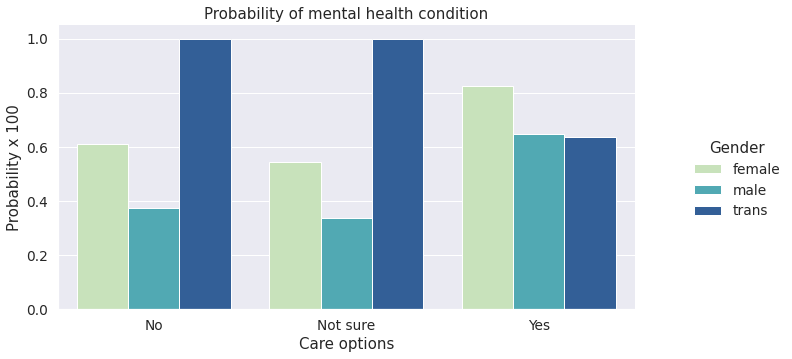

In [19]:
o = labelDict['label_care_options']
g = sns.catplot(x="care_options", y="treatment", hue="Gender", palette=colors, data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for benefits

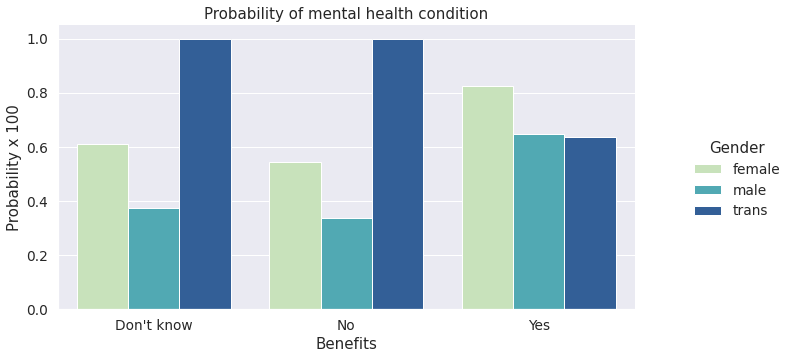

In [20]:
o = labelDict['label_benefits']
g = sns.catplot(x="care_options", y="treatment", hue="Gender",palette=colors, data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for work interfere

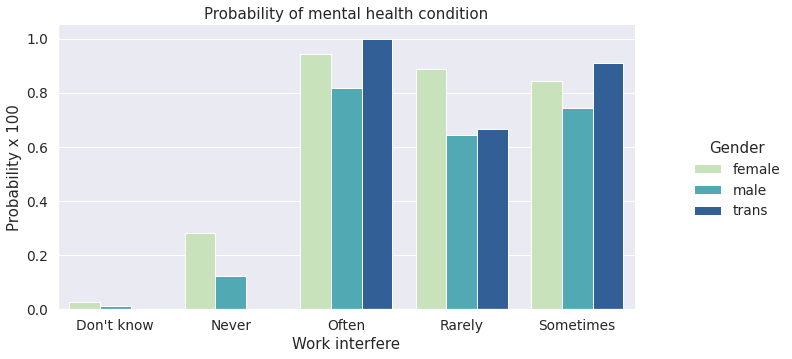

In [21]:
o = labelDict['label_work_interfere']
g = sns.catplot(x="work_interfere", y="treatment", hue="Gender",palette=colors, data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

<a id='Scaling_and_fitting'></a>
## **6. Scaling and fitting** ##



#### Features Scaling
We're going to scale age, because is extremely different from the othere ones.

In [22]:
scaler = MinMaxScaler() #normalize the values
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range,Country
0,0.431818,0,0,0,1,2,4,0,1,2,...,1,1,1,2,1,0,2,0,2,0.908678
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,1,0,0,1,1,0,0,2,0.908678
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,2,2,2,2,1,0,2,0.973599
3,0.295455,1,0,1,1,2,2,0,1,1,...,2,2,1,0,0,0,1,1,2,0.826661
4,0.295455,1,0,0,0,1,1,1,1,2,...,1,1,1,2,2,2,0,0,2,0.908678


Spliltting the dataset

In [23]:
# define X and y
feature_cols = ['work_interfere', 'family_history', 'care_options','benefits', 'obs_consequence', 'anonymity', 'mental_health_interview','wellness_program', 'seek_help']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets selecting at random the 30% of the rows and assigning them to the test_set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

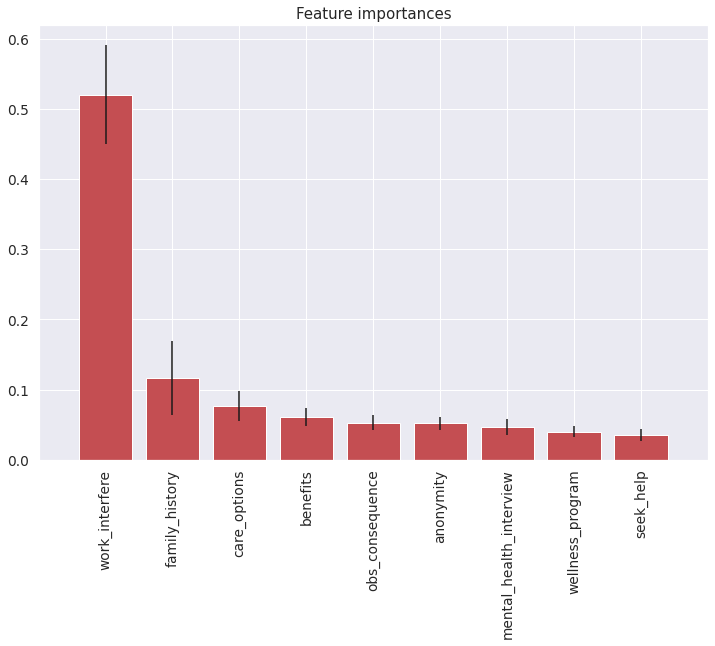

In [24]:
# Tree classifier
forest = ExtraTreesClassifier(n_estimators=250,random_state=0) #This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

#Build a forest and compute the feature importances
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

#selecting only the features' label more relevant
labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

<a id='Tuning'></a>
## **7. Tuning** 
### **Evaluating a Classification Model.** <br>
This function will evalue:<br>
* **Classification accuracy:** percentage of correct predictions
* **Null accuracy:** accuracy that could be achieved by always predicting the most frequent class
* **Percentage of ones**<br>
* **Percentage of zeros**<br>
* **Confusion matrix:** Table that describes the performance of a classification model
        True Positives (TP): we correctly predicted that they do have diabetes
        True Negatives (TN): we correctly predicted that they don't have diabetes
        False Positives (FP): we incorrectly predicted that they do have diabetes (a "Type I error")
        Falsely predict positive
        False Negatives (FN): we incorrectly predicted that they don't have diabetes (a "Type II error")
        Falsely predict negative

* **False Positive Rate**<br>
* **Precision of Positive value**<br>
* **AUC:** is the percentage of the ROC plot that is underneath the curve
        .90-1 = excellent (A)
        .80-.90 = good (B)
        .70-.80 = fair (C)
        .60-.70 = poor (D)
        .50-.60 = fail (F)
And some others values for tuning processes.

In [25]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions

    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    
    #Conclusion:
    #Classification accuracy is the easiest classification metric to understand
    #But, it does not tell you the underlying distribution of response values
    #And, it does not tell you what "types" of errors your classifier is making
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################
    
    #Question: Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?
    #Answer: Plot the ROC curve!
    
    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
       

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        #Sensitivity: When the actual value is positive, how often is the prediction correct?
        #Specificity: When the actual value is negative, how often is the prediction correct?print('Sensitivity for ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)   
    
    return accuracy

### **Tuning with RandomizedSearchCV** ###

In [26]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.cv_results_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)
    
    # run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        #uses only a set of parameters given by the number of iterations
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10) 
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

<a id='Evaluating_models'></a>
## **8. Evaluating models**<br><br>
<a id='Logistic_regression'></a>
### Logistic Regression

In [27]:
def logisticRegression():
    # train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)
    
    print('########### Logistic Regression ###############')
    
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)
    
    #Data for final graph
    methodDict['Log. Regres.'] = accuracy_score * 100

########### Logistic Regression ###############
Accuracy: 0.7936507936507936
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


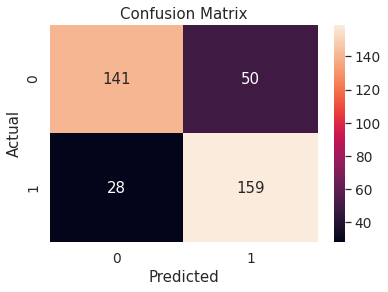

Classification Accuracy: 0.7936507936507936
Classification Error: 0.2063492063492064
False Positive Rate: 0.2617801047120419
Precision: 0.7607655502392344
AUC Score: 0.7942436374835513
Cross-validated AUC: 0.8738650384735734
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 0 0]
First 10 predicted probabilities of class members:
 [[0.06593352 0.93406648]
 [0.94422439 0.05577561]
 [0.96463727 0.03536273]
 [0.80169514 0.19830486]
 [0.37764886 0.62235114]
 [0.02049528 0.97950472]
 [0.80787163 0.19212837]
 [0.28553251 0.71446749]
 [0.59329055 0.40670945]
 [0.6161953  0.3838047 ]]
First 10 predicted probabilities:
 [[0.93406648]
 [0.05577561]
 [0.03536273]
 [0.19830486]
 [0.62235114]
 [0.97950472]
 [0.19212837]
 [0.71446749]
 [0.40670945]
 [0.3838047 ]]


/home/martina/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


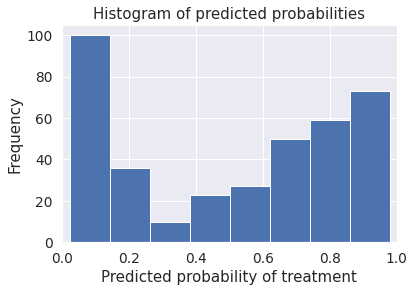

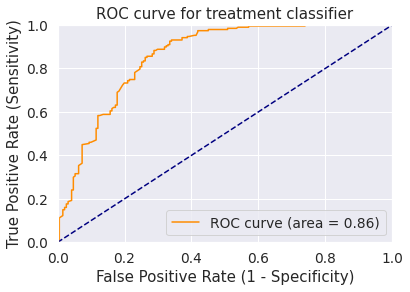

[[141  50]
 [ 28 159]]


In [28]:
logisticRegression()

<a id='KNeighborsClassifier'></a>
### KNeighbors Classifier

In [29]:
def Knn():
    # Calculating the best parameters
    knn = KNeighborsClassifier(n_neighbors=5)
       
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance'] # distance: more weight to more similar values
    distance_options = [1,2,3] # different types of distances (manhattan, euclidean, minkowksi)
    # algorithm used is the best among  ‘ball_tree’, ‘kd_tree’, ‘brute’
    
    # specify "parameter distributions" rather than a "parameter grid"
    param_dist = dict(n_neighbors=k_range, weights=weight_options, p=distance_options)
    tuningRandomizedSearchCV(knn, param_dist)
    
    # train a KNeighborsClassifier model on the training set
    knn = KNeighborsClassifier(n_neighbors=11, weights='uniform',p=2)
    knn.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = knn.predict(X_test)
    
    print('########### KNeighborsClassifier ###############')
    
    accuracy_score = evalClassModel(knn, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['KNN'] = accuracy_score * 100


Rand. Best Score:  0.831352380952381
Rand. Best Params:  {'weights': 'uniform', 'p': 2, 'n_neighbors': 11}
[0.827, 0.825, 0.823, 0.815, 0.823, 0.83, 0.823, 0.827, 0.817, 0.819, 0.821, 0.825, 0.826, 0.827, 0.827, 0.827, 0.828, 0.821, 0.831, 0.831]
########### KNeighborsClassifier ###############
Accuracy: 0.8174603174603174
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0]


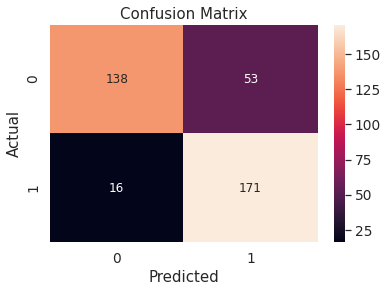

Classification Accuracy: 0.8174603174603174
Classification Error: 0.18253968253968256
False Positive Rate: 0.2774869109947644
Precision: 0.7633928571428571
AUC Score: 0.8184757958395162
Cross-validated AUC: 0.8820187984094474
First 10 predicted responses:
 [1 0 0 0 1 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.18181818 0.81818182]
 [1.         0.        ]
 [1.         0.        ]
 [0.90909091 0.09090909]
 [0.36363636 0.63636364]
 [0.         1.        ]
 [1.         0.        ]
 [0.63636364 0.36363636]
 [0.         1.        ]
 [0.45454545 0.54545455]]
First 10 predicted probabilities:
 [[0.81818182]
 [0.        ]
 [0.        ]
 [0.09090909]
 [0.63636364]
 [1.        ]
 [0.        ]
 [0.36363636]
 [1.        ]
 [0.54545455]]


/home/martina/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


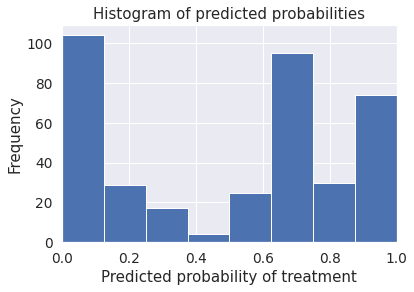

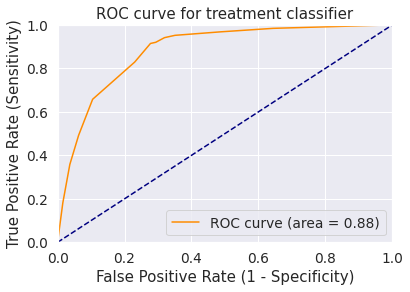

[[138  53]
 [ 16 171]]


In [30]:
Knn()

#### KNN - Our implementation

<a id='Decision_Tree_classifier'></a>
### Decision Tree classifier

In [31]:
def treeClassifier():
    # Calculating the best parameters
    tree = DecisionTreeClassifier()
    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(tree, param_dist)
    
    # train a decision tree model on the training set
    tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
    tree.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = tree.predict(X_test)
    
    print('########### Tree classifier ###############')
    
    accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Tree clas.'] = accuracy_score * 100

Rand. Best Score:  0.8305206349206349
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 8}
[0.826, 0.831, 0.831, 0.831, 0.831, 0.831, 0.829, 0.831, 0.831, 0.831, 0.831, 0.831, 0.828, 0.829, 0.826, 0.831, 0.831, 0.831, 0.831, 0.828]
########### Tree classifier ###############
Accuracy: 0.8068783068783069
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


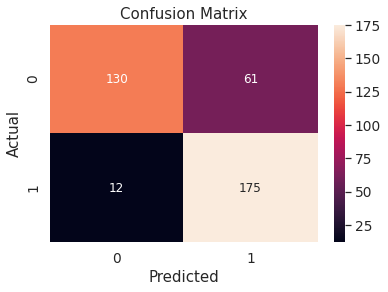

Classification Accuracy: 0.8068783068783069
Classification Error: 0.19312169312169314
False Positive Rate: 0.3193717277486911
Precision: 0.7415254237288136
AUC Score: 0.8082285746283282
Cross-validated AUC: 0.8852351788609709
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.18823529 0.81176471]
 [1.         0.        ]
 [0.98969072 0.01030928]
 [0.79166667 0.20833333]
 [0.36969697 0.63030303]
 [0.05172414 0.94827586]
 [0.79166667 0.20833333]
 [0.36969697 0.63030303]
 [0.20430108 0.79569892]
 [0.20430108 0.79569892]]
First 10 predicted probabilities:
 [[0.81176471]
 [0.        ]
 [0.01030928]
 [0.20833333]
 [0.63030303]
 [0.94827586]
 [0.20833333]
 [0.63030303]
 [0.79569892]
 [0.79569892]]


/home/martina/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


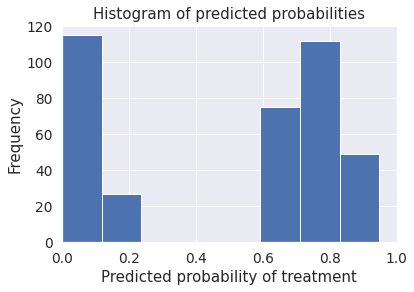

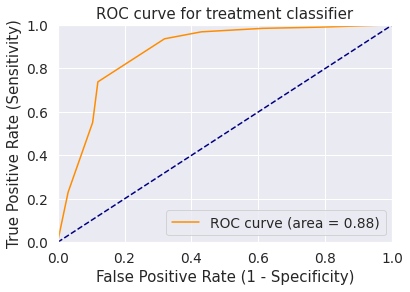

[[130  61]
 [ 12 175]]


In [32]:
treeClassifier()

<a id='Random_Forests'></a>
### Random Forests

In [33]:
def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(forest, param_dist)
    
    # Building and fitting my_forest
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)
    
    print('########### Random Forests ###############')
    
    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['R. Forest'] = accuracy_score * 100

Rand. Best Score:  0.835326984126984
Rand. Best Params:  {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 8, 'min_samples_split': 2}
[0.834, 0.831, 0.831, 0.83, 0.832, 0.834, 0.831, 0.831, 0.831, 0.831, 0.831, 0.833, 0.831, 0.831, 0.834, 0.831, 0.831, 0.834, 0.831, 0.831]
########### Random Forests ###############
Accuracy: 0.8121693121693122
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


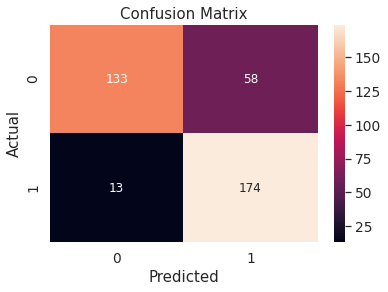

Classification Accuracy: 0.8121693121693122
Classification Error: 0.1878306878306878
False Positive Rate: 0.3036649214659686
Precision: 0.75
AUC Score: 0.8134081809782457
Cross-validated AUC: 0.8900849876614325
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.14835761 0.85164239]
 [0.99013158 0.00986842]
 [0.98225279 0.01774721]
 [0.88950347 0.11049653]
 [0.37026231 0.62973769]
 [0.1144077  0.8855923 ]
 [0.8229772  0.1770228 ]
 [0.40874818 0.59125182]
 [0.14448488 0.85551512]
 [0.28490525 0.71509475]]
First 10 predicted probabilities:
 [[0.85164239]
 [0.00986842]
 [0.01774721]
 [0.11049653]
 [0.62973769]
 [0.8855923 ]
 [0.1770228 ]
 [0.59125182]
 [0.85551512]
 [0.71509475]]


/home/martina/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


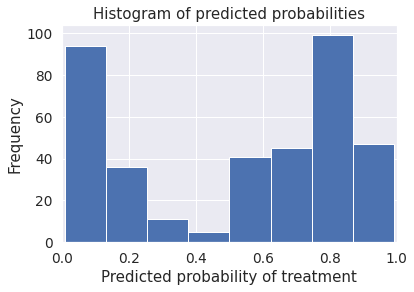

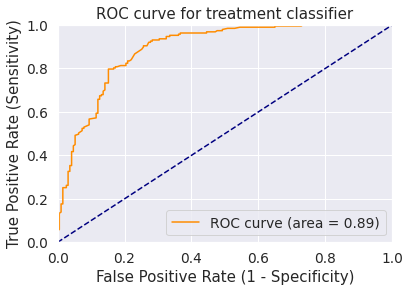

[[133  58]
 [ 13 174]]


In [34]:
randomForest()

<a id='Bagging'></a>
### Bagging

In [35]:
def bagging():
    # Building and fitting 
    bag = BaggingClassifier(DecisionTreeClassifier(), max_samples=1.0, max_features=1.0, bootstrap_features=False)
    bag.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = bag.predict(X_test)
    
    print('########### Bagging ###############')
    
    accuracy_score = evalClassModel(bag, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Bagging'] = accuracy_score * 100

########### Bagging ###############
Accuracy: 0.7777777777777778
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


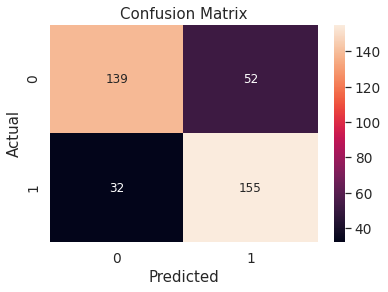

Classification Accuracy: 0.7777777777777778
Classification Error: 0.2222222222222222
False Positive Rate: 0.27225130890052357
Precision: 0.748792270531401
AUC Score: 0.7783128482235349
Cross-validated AUC: 0.844608162858931
First 10 predicted responses:
 [1 0 0 0 1 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.21       0.79      ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.19305556 0.80694444]
 [0.2        0.8       ]
 [1.         0.        ]
 [0.83878788 0.16121212]
 [0.         1.        ]
 [0.26833333 0.73166667]]
First 10 predicted probabilities:
 [[0.79      ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.80694444]
 [0.8       ]
 [0.        ]
 [0.16121212]
 [1.        ]
 [0.73166667]]


/home/martina/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


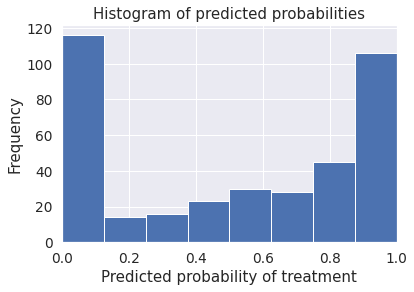

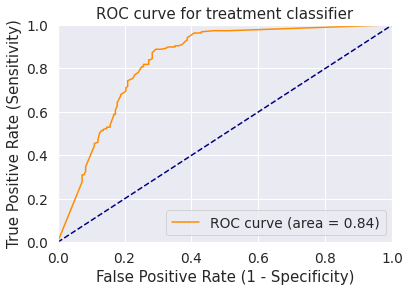

[[139  52]
 [ 32 155]]


In [36]:
bagging()

<a id='Boosting'></a>
### Boosting

In [37]:
def boosting():
    # Building and fitting 
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(base_estimator=clf, n_estimators=500)
    boost.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = boost.predict(X_test)
    
    print('########### Boosting ###############')
    
    accuracy_score = evalClassModel(boost, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Boosting'] = accuracy_score * 100

########### Boosting ###############
Accuracy: 0.8148148148148148
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


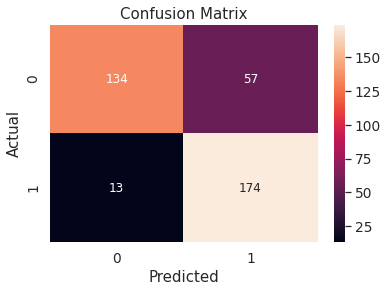

Classification Accuracy: 0.8148148148148148
Classification Error: 0.18518518518518523
False Positive Rate: 0.29842931937172773
Precision: 0.7532467532467533
AUC Score: 0.8160259820253661
Cross-validated AUC: 0.8984230927287282
First 10 predicted responses:
 [1 0 0 0 1 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.49897158 0.50102842]
 [0.50274872 0.49725128]
 [0.50279582 0.49720418]
 [0.50107643 0.49892357]
 [0.49980082 0.50019918]
 [0.49854748 0.50145252]
 [0.50086951 0.49913049]
 [0.5000295  0.4999705 ]
 [0.49907554 0.50092446]
 [0.49913734 0.50086266]]
First 10 predicted probabilities:
 [[0.50102842]
 [0.49725128]
 [0.49720418]
 [0.49892357]
 [0.50019918]
 [0.50145252]
 [0.49913049]
 [0.4999705 ]
 [0.50092446]
 [0.50086266]]


/home/martina/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


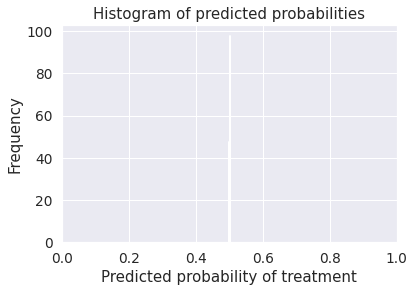

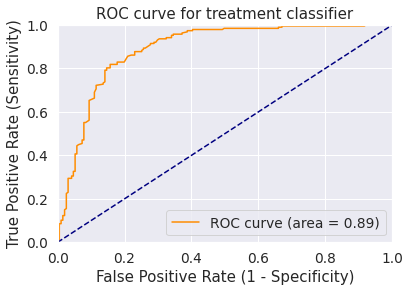

[[134  57]
 [ 13 174]]


In [38]:
boosting()

<a id='Stacking'></a>
### Stacking

In [39]:
def stacking():
    # Building and fitting 
    clf1 = KNeighborsClassifier(n_neighbors=1)
    clf2 = RandomForestClassifier(random_state=1)
    #maybe add the clf3 = decisionforest ()
    lr = LogisticRegression()
    stack = StackingClassifier(classifiers=[clf1, clf2], meta_classifier=lr)
    stack.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = stack.predict(X_test)
    
    print('########### Stacking ###############')
    
    accuracy_score = evalClassModel(stack, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Stacking'] = accuracy_score * 100
    


########### Stacking ###############
Accuracy: 0.7936507936507936
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0]


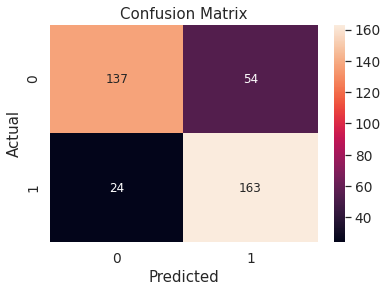

Classification Accuracy: 0.7936507936507936
Classification Error: 0.2063492063492064
False Positive Rate: 0.28272251308900526
Precision: 0.7511520737327189
AUC Score: 0.794467620460845
Cross-validated AUC: 0.8094748317860596
First 10 predicted responses:
 [1 0 0 0 1 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.40754366 0.59245634]
 [0.94207164 0.05792836]
 [0.94207164 0.05792836]
 [0.94207164 0.05792836]
 [0.06468178 0.93531822]
 [0.06468178 0.93531822]
 [0.94207164 0.05792836]
 [0.94207164 0.05792836]
 [0.06468178 0.93531822]
 [0.06468178 0.93531822]]
First 10 predicted probabilities:
 [[0.59245634]
 [0.05792836]
 [0.05792836]
 [0.05792836]
 [0.93531822]
 [0.93531822]
 [0.05792836]
 [0.05792836]
 [0.93531822]
 [0.93531822]]


/home/martina/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


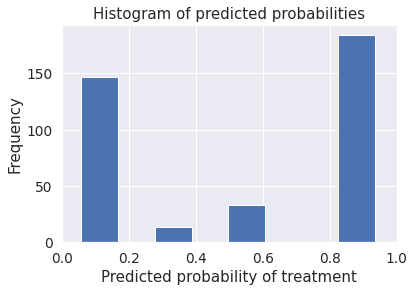

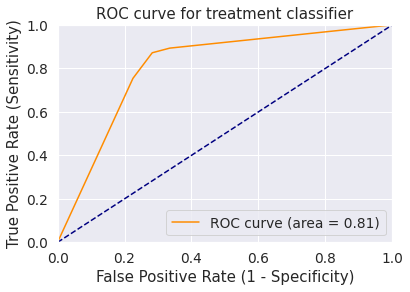

[[137  54]
 [ 24 163]]


In [40]:
stacking()

<a id='Success_method_plot'></a>
## **10. Success method plot**

In [43]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
    plt.show()

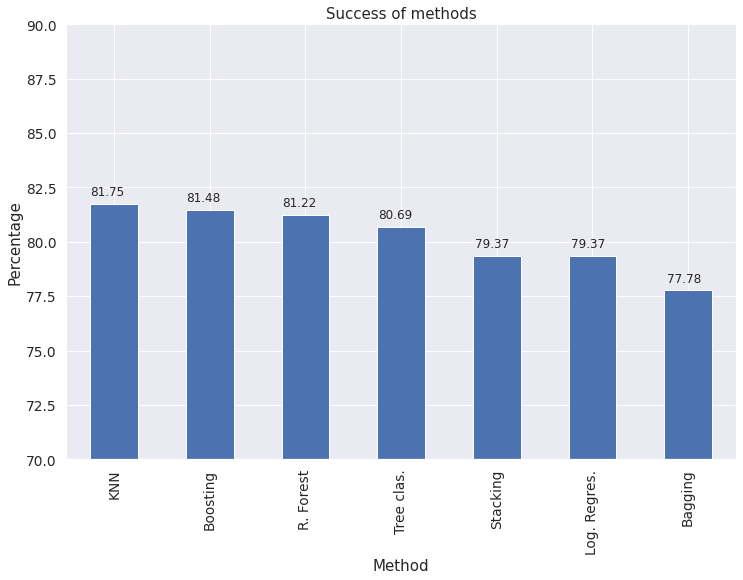

In [44]:
plotSuccess()

<a id='Creating_predictions_on_test_set'></a>
## **11. Creating predictions on test set**

In [45]:
# Generate predictions with the best method
clf = AdaBoostClassifier()
clf.fit(X, y)
dfTestPredictions = clf.predict(X_test)

# Write predictions to csv file
# We don't have any significative field so we save the index
results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})
# Save to file
# This file will be visible after publishing in the output section
results.to_csv('results.csv', index=False)
results.head()

,Index,Treatment
0,5,1
1,494,0
2,52,0
3,984,0
4,186,1


## 12. Our Implemetations 

### Evaluation 

In [46]:
def evalImplemented(y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions

    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print( y_pred_class)
    print('Pred:', y_pred_class[0:25])
    
    #Conclusion:
    #Classification accuracy is the easiest classification metric to understand
    #But, it does not tell you the underlying distribution of response values
    #And, it does not tell you what "types" of errors your classifier is making
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    return accuracy

### Logistic Regression

In this section we want to test our own code for the logistic regression by using the gradient ascent algorithm. First of all we adapted the training set to the required input, then we added an additional function (*coefficients_sgd*) in order to get the optimal starting value for the theta parameter (*theta0*). For the learning rate and for the number of epochs to be used in the regression, we have initially put into practice what we learned from the previous homework by using the best combination for these two parameters. Furthermore, we will test different combinations to check if another combination better suits this dataset.

Accuracy: 0.7433862433862434
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1

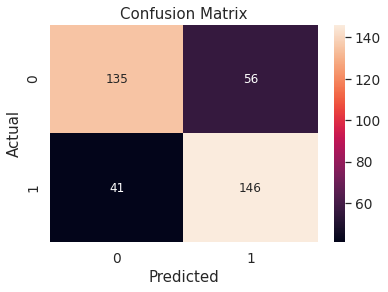

Classification Accuracy: 0.7433862433862434
Classification Error: 0.2566137566137566
False Positive Rate: 0.2931937172774869
Precision: 0.7227722772277227
AUC Score: 0.7437774729120586


0.7433862433862434

In [47]:
# convert df to np
x_vec1 = np.hstack([X_train[['work_interfere', 'family_history', 'care_options',
       'benefits', 'obs_consequence', 'anonymity', 'mental_health_interview',
       'wellness_program', 'seek_help']].values])
y_vec1 = y_train.values

# keep in mind that the function predict can be sobtituted with the one from the magic book
def predict(x,theta):
    z = np.dot(x,theta)
    g = 1/(1 + np.exp(-z))
    #the sigmoid of x changes according to the value of x. In case  x = 0, g(x)= 1/2; in case x -> +inf g(x) tends to 1; in case x -> -inf g(x) tends to 0
    return g # return the sigmoid of x

def coefficients_sgd(train, l_rate, n_epoch):
    theta = [0.0 for i in range(len(train[0]))]
    for _ in range(n_epoch):
        for row in train:
            yhat = predict(row, theta)
            error = row[-1] - yhat
            theta[0] = theta[0] + l_rate * error * yhat * (1.0 - yhat)
            for i in range(len(row)-1):
                theta[i + 1] = theta[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
    return theta

theta0 = coefficients_sgd(x_vec1,0.3,50) # parameters to be considered (were good from hw2)

def log_likelihood(theta,x,y):
    h_theta = predict(x,theta)
    eps = 10**(-5) # avoid division by zero
    log_l= sum(y*np.log(h_theta) + (1-y)*np.log(1+eps-h_theta))/len(y)
    return log_l # return the log likehood of theta according to data x and label y

def grad_l(theta, x, y):
    m = len(y)
    h_theta=predict(x,theta)
    G = np.dot((y-h_theta),x)/m
    
    return G # return the gradient G of the log likelihood

def gradient_ascent(theta,x,y,G,alpha,iterations):
    m = len(y)
    log_l_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,9)) 
        
    for i in range(1,iterations):
        hypothesis = predict(x, theta) 
        log_l_history[i] = log_likelihood(theta,x,y)
        theta = theta_history[i-1] + (alpha*G(theta,x,y))
        theta_history[i] = theta        
        
    return theta, log_l_history, theta_history #as well as two lists containing the log likelihood's and values of theta at all iterations

theta_final, log_l_history, theta_history = gradient_ascent(theta0,x_vec1,y_vec1,grad_l,alpha=0.8,iterations=80)

'''
Now we want to classify each sample according to the log likelihood obtained with the product of the theta final vector and each sample features. 
We assume that if the log-likelihood is greater or equal than 0.5, then we classify one sample as "treatment yes" , "treatment no" otherwise.'''

y_pred1 = []
X_trasp = X_test.T
samples = X_trasp.columns
for i in range(len(X_trasp.columns)):
    x = X_trasp.iloc[:,i]
    l = np.dot(x,theta_final)
    if l >= 0.5:
        y_pred1.append(1)
    else:
        y_pred1.append(0)
        
evalImplemented(y_test,y_pred1)

### KNN

<ipython-input-48-ab82987388f2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['y'] = y_train


Accuracy: 0.8121693121693122
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1

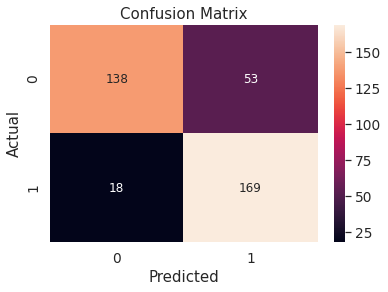

Classification Accuracy: 0.8121693121693122
Classification Error: 0.1878306878306878
False Positive Rate: 0.2774869109947644
Precision: 0.7612612612612613
AUC Score: 0.8131282022566285


0.8121693121693122

In [48]:
def euclidean_distance(testR, trainR):
    distance = 0
    for i in range(len(testR)-1):
        distance += (testR[i] - trainR[i])**2
    return sqrt(distance)

def get_neighbors(train_df, testR, num_neighbors):
    distances = list()
    for i in train_df.iterrows():
        trainR = list(i[1])
        dist = euclidean_distance(testR, trainR)
        distances.append((trainR, dist))
        distances.sort(key=lambda tup: tup[1])
        neighbors = []
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

def predict_classification(X_train, X_test, y_train, num_neighbors):
    train_set = X_train
    train_set['y'] = y_train
    
    y_pred = []
    for i in X_test.iterrows():
        testR = list(i[1])
        neighbors = get_neighbors(train_set, testR, num_neighbors)
        output_values = [row[-1] for row in neighbors]
        prediction = max(set(output_values), key=output_values.count)
        y_pred.append(prediction)
    
    return y_pred

y_pred2 = predict_classification(X_train ,X_test, y_train, 11)
evalImplemented(y_test,y_pred2)